In [160]:
import requests
import json
import datetime
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set(rc={'figure.figsize':(17,8.27)})
pd.options.display.float_format = '{:.2f}'.format
import ta
#from ETH_parser import get_floor_price, get_sales_collection, get_sales_token, get_attributes, get_attributes_collection, get_rarity, get_block_timestamp

In [27]:
API_KEY = "vYHU2nVXBMrIHlByeFOQWubnRQcl_v_3"
BAYC = "0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d"
AZUKI = "0xed5af388653567af2f388e6224dc7c4b3241c544"

In [3]:
def get_floor_price(API: str, address: str) -> dict:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/getFloorPrice?contractAddress={address}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    prices = {"opensea": data['openSea']['floorPrice'],
              "looksrare": data['looksRare']['floorPrice']}

    return prices

In [4]:
# OLD
# def get_sales_collection(API: str, address: str, limit: int) -> json:
#     url = f"https://eth-mainnet.g.alchemy.com/nft/v3/{API}/getNFTSales?fromBlock=0&toBlock=latest&order=desc&marketplace=seaport&contractAddress={address}&limit={limit}"
#     headers = {"accept": "application/json"}
#     response = requests.get(url, headers=headers)
#     data = json.loads(response.text)

    
#     activity = [{"tokenId": sale["tokenId"],
#                  "marketplace": sale["marketplace"],
#                  "block": sale["blockNumber"],
#                  "token": sale["sellerFee"]["symbol"],
#                  "price": 0 if sale["sellerFee"]["amount"] is None else int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]

#     return activity

In [59]:
def get_sales_collection(API: str, address: str, to_block, limit: int):
    url = f"https://eth-mainnet.g.alchemy.com/nft/v3/{API}/getNFTSales?fromBlock=0&toBlock={to_block}&order=desc&contractAddress={address}&limit={limit}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)

    activity = [{"tokenId": sale["tokenId"],
                 "marketplace": sale["marketplace"],
                 "block": sale["blockNumber"],
                 "token": sale["sellerFee"]["symbol"],
                 "price": 0 if sale["sellerFee"]["amount"] is None else int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]

    return pd.DataFrame(activity)

In [6]:
def get_sales_token(API: str, address: str, limit: int, tokenId: int) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/getNFTSales?fromBlock=0&toBlock=latest&order=desc&contractAddress={address}&limit={limit}&tokenId={tokenId}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    activity = [{"tokenId": sale["tokenId"],
                 "marketplace": sale["marketplace"],
                 "sellerFee": int(sale["sellerFee"]["amount"]) / 10 ** 18} for sale in data["nftSales"]]
    
    return activity

In [7]:
def get_attributes(API: str, address: str, tokenId: int) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/computeRarity?contractAddress={address}&tokenId={tokenId}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)

    return data

In [8]:
def get_attributes_collection(API: str, address: str) -> json:
    url = f"https://eth-mainnet.g.alchemy.com/nft/v2/{API}/summarizeNFTAttributes?contractAddress={address}"
    headers = {"accept": "application/json"}
    response = requests.get(url, headers=headers)
    data = json.loads(response.text)
    
    return data['summary']

In [9]:
def get_rarity(API: str, address: str, tokenId: int) -> json:
    data = get_attributes(API=API, address=address, tokenId=tokenId)
    
    result = 1
    for rarity in data:
        result *= rarity["prevalence"]
        
    return result

In [10]:
def get_block_timestamp(block_number):
    url = f"https://eth-mainnet.alchemyapi.io/v2/{API_KEY}"
    payload = json.dumps({
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber",
        "params": [hex(block_number), False],
        "id": 1
    })
    headers = {
        'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload)
    if response.status_code == 200:
        timestamp = response.json()['result']['timestamp']
        date_time = datetime.utcfromtimestamp(int(timestamp, 16))
        return date_time
    else:
        return "error"

In [39]:
bayc_data_1 = get_sales_collection(API=API_KEY, address=BAYC, to_block='latest', limit=1000)
next_block = bayc_data_1.block.min()
bayc_data_2 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_2.block.min()
bayc_data_3 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_3.block.min()
bayc_data_4 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_4.block.min()
bayc_data_5 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)

bayc_data = pd.concat([bayc_data_1, bayc_data_2, bayc_data_3, bayc_data_4, bayc_data_5], ignore_index=True)
bayc_data.to_csv('bayc_raw.csv')

,tokenId,marketplace,block,token,price
0,4284,blur,17429314,,46.17
1,428,blur,17429300,,46.17
2,1032,blur,17429285,,46.26
3,3391,blur,17429281,,46.26
4,2578,blur,17429277,,46.33
...,...,...,...,...,...
4995,7525,seaport,16589544,ETH,74.45
4996,3611,blur,16589319,ETH,74.62
4997,3611,x2y2,16589184,ETH,84.39
4998,3634,looksrare,16588074,WETH,66.05


In [45]:
bayc_blocks = bayc_data.copy().drop_duplicates(subset='block')
bayc_blocks['date'] = bayc_blocks['block'].apply(get_block_timestamp)
bayc_blocks.to_csv('bayc_5000.csv')

,tokenId,marketplace,block,token,price
0,4284,blur,17429314,,46.17
1,428,blur,17429300,,46.17
2,1032,blur,17429285,,46.26
3,3391,blur,17429281,,46.26
4,2578,blur,17429277,,46.33
...,...,...,...,...,...
4995,7525,seaport,16589544,ETH,74.45
4996,3611,blur,16589319,ETH,74.62
4997,3611,x2y2,16589184,ETH,84.39
4998,3634,looksrare,16588074,WETH,66.05


# Save Data

In [110]:
bayc_data_1 = get_sales_collection(API=API_KEY, address=BAYC, to_block='latest', limit=1000)
next_block = bayc_data_1.block.min()
bayc_data_2 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_2.block.min()
bayc_data_3 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_3.block.min()
bayc_data_4 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_4.block.min()
bayc_data_5 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_5.block.min()
bayc_data_6 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)
next_block = bayc_data_6.block.min()
bayc_data_7 = get_sales_collection(API=API_KEY, address=BAYC, to_block=next_block, limit=1000)


bayc_data = pd.concat([bayc_data_1, bayc_data_2, bayc_data_3, bayc_data_4, bayc_data_5, bayc_data_6, bayc_data_7], ignore_index=True)
bayc_data.to_csv('bayc_raw.csv')

In [ ]:
bayc_blocks = bayc_data.copy().drop_duplicates(subset='block')
bayc_blocks['date'] = bayc_blocks['block'].apply(get_block_timestamp)
bayc_blocks.to_csv('bayc_w_time.csv')

In [123]:
bayc_rarity = bayc_data.copy().drop_duplicates(subset='tokenId')
bayc_rarity['rarity'] = bayc_rarity['tokenId'].apply(lambda x: get_rarity(API=API_KEY, address=BAYC, tokenId=x))
bayc_rarity['rarity'] = bayc_rarity['rarity'] * 10000000000000000
bayc_rarity.to_csv('bayc_w_rarity.csv')

# Read data and create final df

In [266]:
bayc_info = pd.read_csv('bayc_raw_data.csv')
bayc_rarity = pd.read_csv('bayc_w_rarity.csv')
bayc_time = pd.read_csv('bayc_w_time.csv')

In [267]:
bayc_df = bayc_info.join(bayc_rarity[['tokenId', 'rarity']].set_index('tokenId'), on='tokenId', how='left')
bayc_df = bayc_df.join(bayc_time[['block', 'date']].set_index('block'), on='block', how='left')
bayc_df = bayc_df.drop('Unnamed: 0', axis=1)

bayc_df.head()

,tokenId,marketplace,block,token,price,rarity,date
0,8507,seaport,17452752,WETH,45.50,1894522593.60,2023-06-10 22:32:23
1,6360,seaport,17452629,ETH,47.23,1724974815.60,2023-06-10 22:07:35
2,6891,blur,17452371,NaN,45.54,33034156.13,2023-06-10 21:15:47
3,5609,blur,17452346,ETH,50.75,56649961.29,2023-06-10 21:10:47
4,2844,blur,17452125,NaN,45.65,4763302967.40,2023-06-10 20:25:59


# EDA

In [163]:
bayc_df.head(5)

,tokenId,marketplace,block,token,price,rarity,date,price_rounded,price_binned
0,8507,seaport,17452752,WETH,45.50,1894522593.60,2023-06-10 22:32:23,46.00,"[45, 50)"
1,6360,seaport,17452629,ETH,47.23,1724974815.60,2023-06-10 22:07:35,47.00,"[45, 50)"
2,6891,blur,17452371,NaN,45.54,33034156.13,2023-06-10 21:15:47,46.00,"[45, 50)"
3,5609,blur,17452346,ETH,50.75,56649961.29,2023-06-10 21:10:47,51.00,"[50, 55)"
4,2844,blur,17452125,NaN,45.65,4763302967.40,2023-06-10 20:25:59,46.00,"[45, 50)"


In [147]:
bayc_df.describe()

,tokenId,block,price,rarity
count,7000.00,7000.00,7000.00,7000.00
mean,5014.18,16887861.76,60.22,9710862013.75
std,2880.16,395353.49,22.94,83889993615.47
min,5.00,16185032.00,0.00,69024.88
25%,2578.00,16641828.00,46.75,90751157.17
50%,4868.00,16892693.50,60.33,483669803.17
75%,7440.00,17241469.00,69.99,2676048127.66
max,9996.00,17452752.00,800.00,4610806409880.00


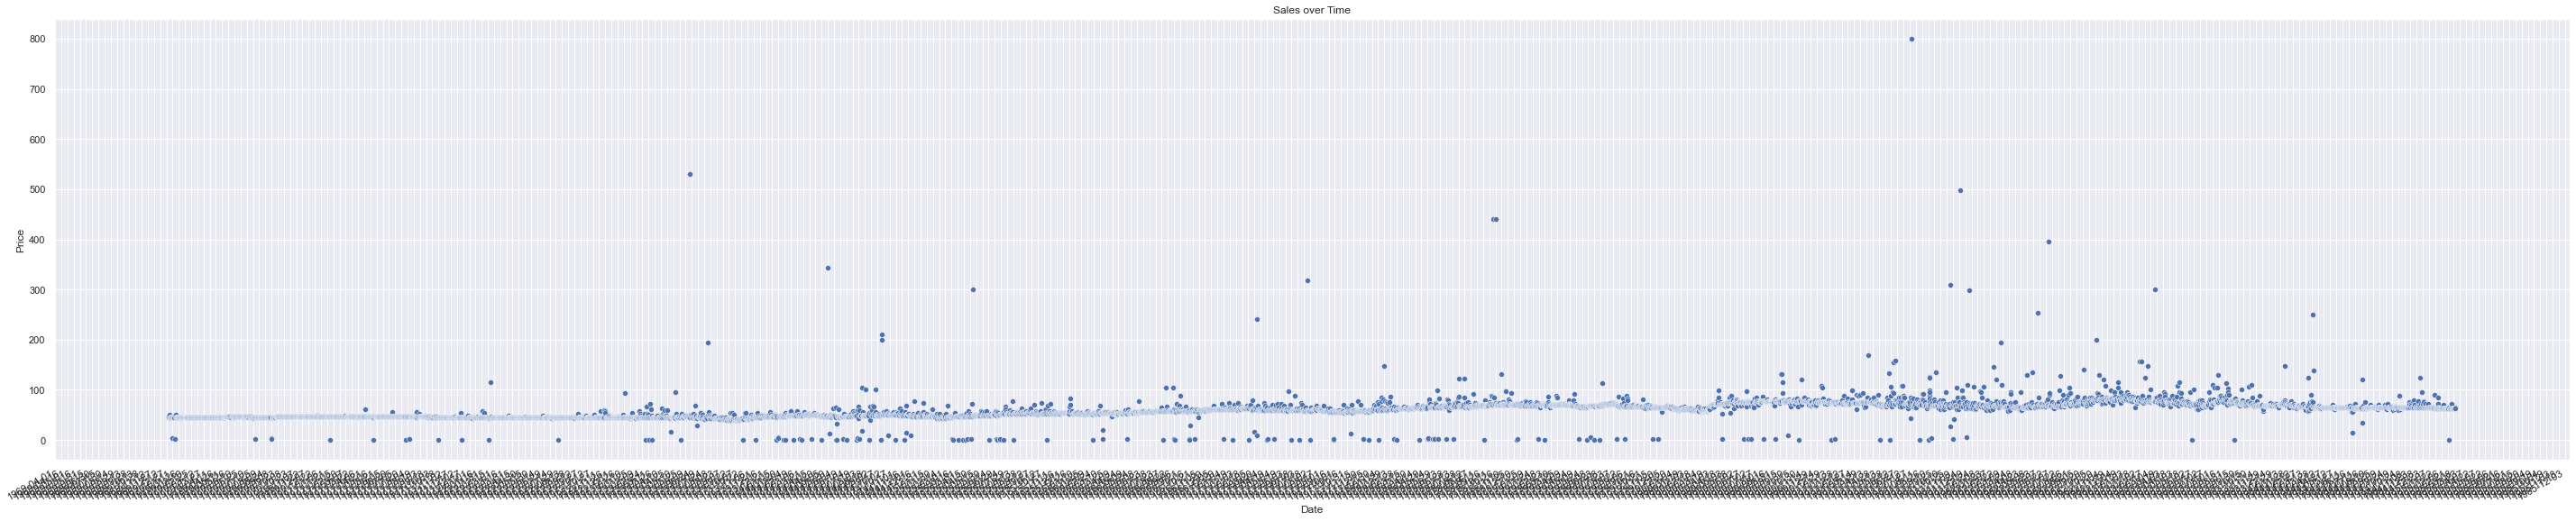

In [162]:
# Price destribution

plt.figure(figsize=(50,10))
sns.scatterplot(data=bayc_df, x='date', y='price')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Sales over Time')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))  
plt.gcf().autofmt_xdate() 

plt.show()


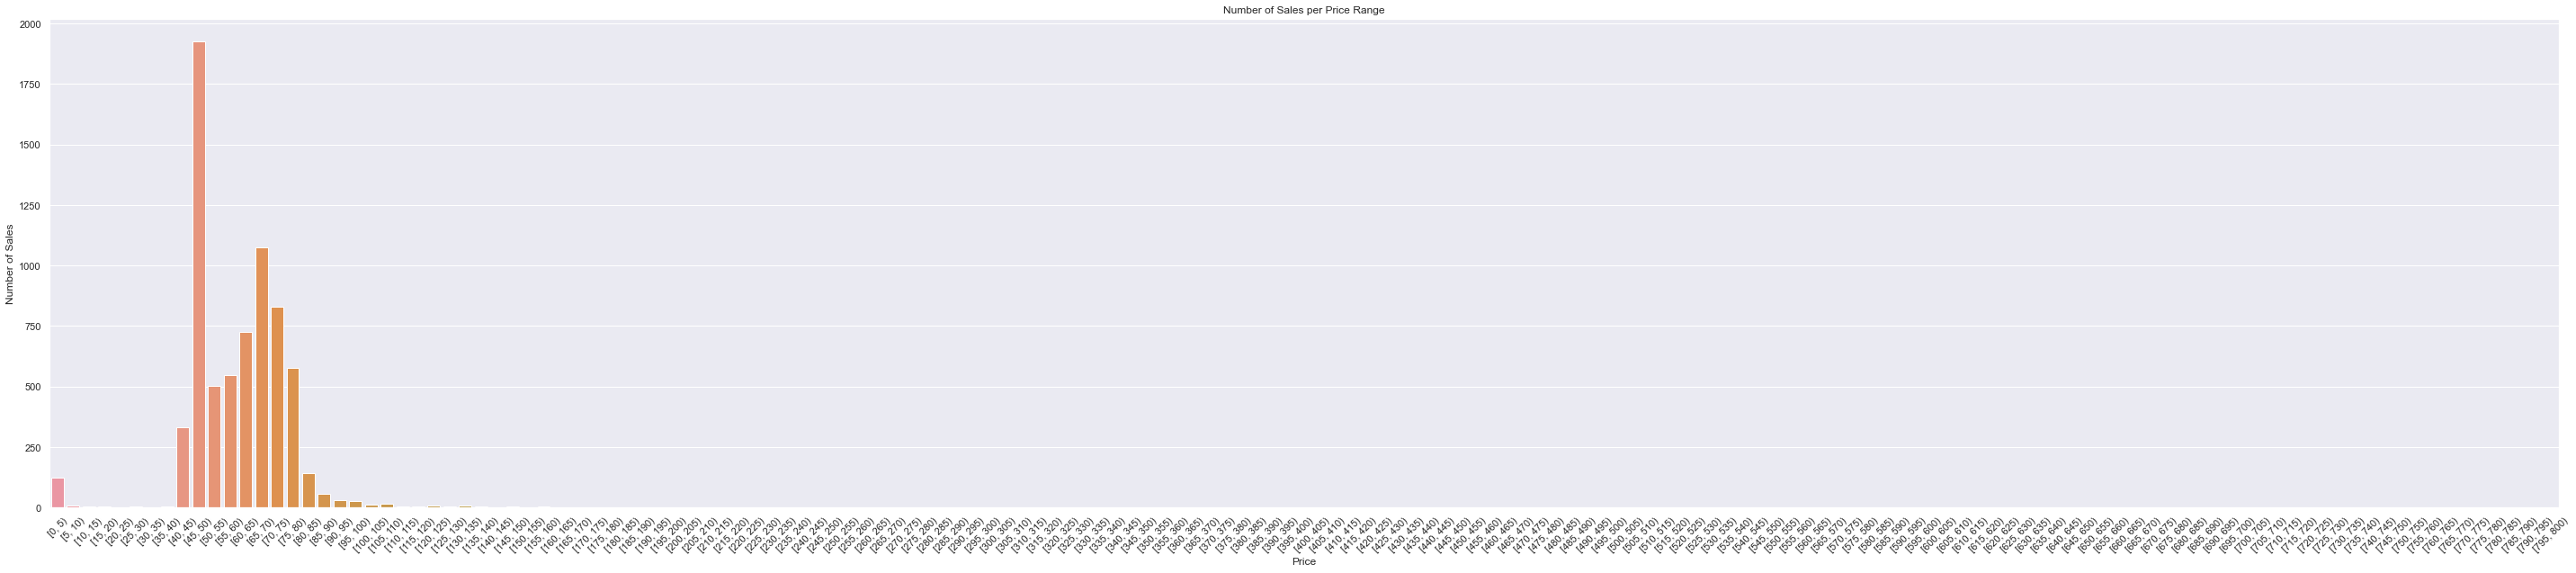

,price,count
9,"[0, 5)",122
16,"[5, 10)",7
22,"[10, 15)",4
21,"[15, 20)",4
27,"[25, 30)",3
46,"[30, 35)",1
18,"[35, 40)",6
7,"[40, 45)",333
0,"[45, 50)",1925
6,"[50, 55)",501


In [158]:
# Number of sales per price binned with step 5

bins = list(range(0, int(bayc_df['price'].max()) + 5, 5))

bayc_df['price_binned'] = pd.cut(bayc_df['price'], bins=bins, include_lowest=True, right=False)

price_counts = bayc_df['price_binned'].value_counts().reset_index()
price_counts.columns = ['price', 'count']
price_counts = price_counts[price_counts['count'] > 0]

plt.figure(figsize=(50,10))
sns.barplot(x='price', y='count', data=price_counts)
plt.xlabel('Price')
plt.ylabel('Number of Sales')
plt.title('Number of Sales per Price Range')
plt.xticks(rotation=45)
plt.show()

price_counts.sort_values('price', ascending=True)

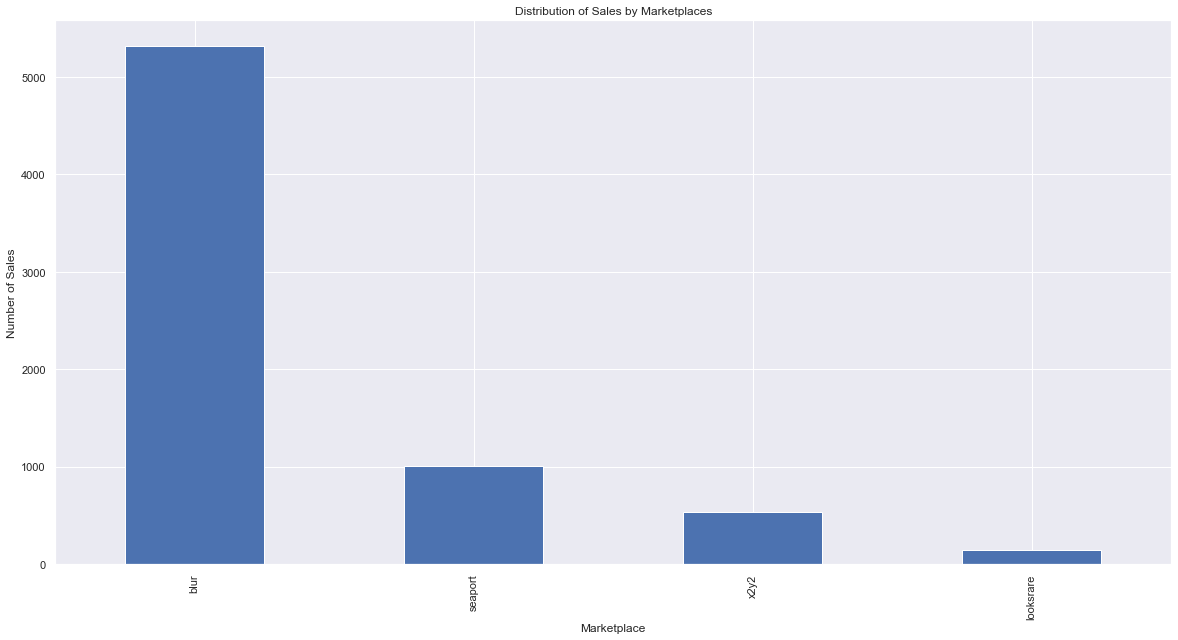

In [170]:
# Distribution of sales by marketplaces

plt.figure(figsize=(20,10))
bayc_df['marketplace'].value_counts().plot(kind='bar')
plt.xlabel('Marketplace')
plt.ylabel('Number of Sales')
plt.title('Distribution of Sales by Marketplaces')
plt.show()

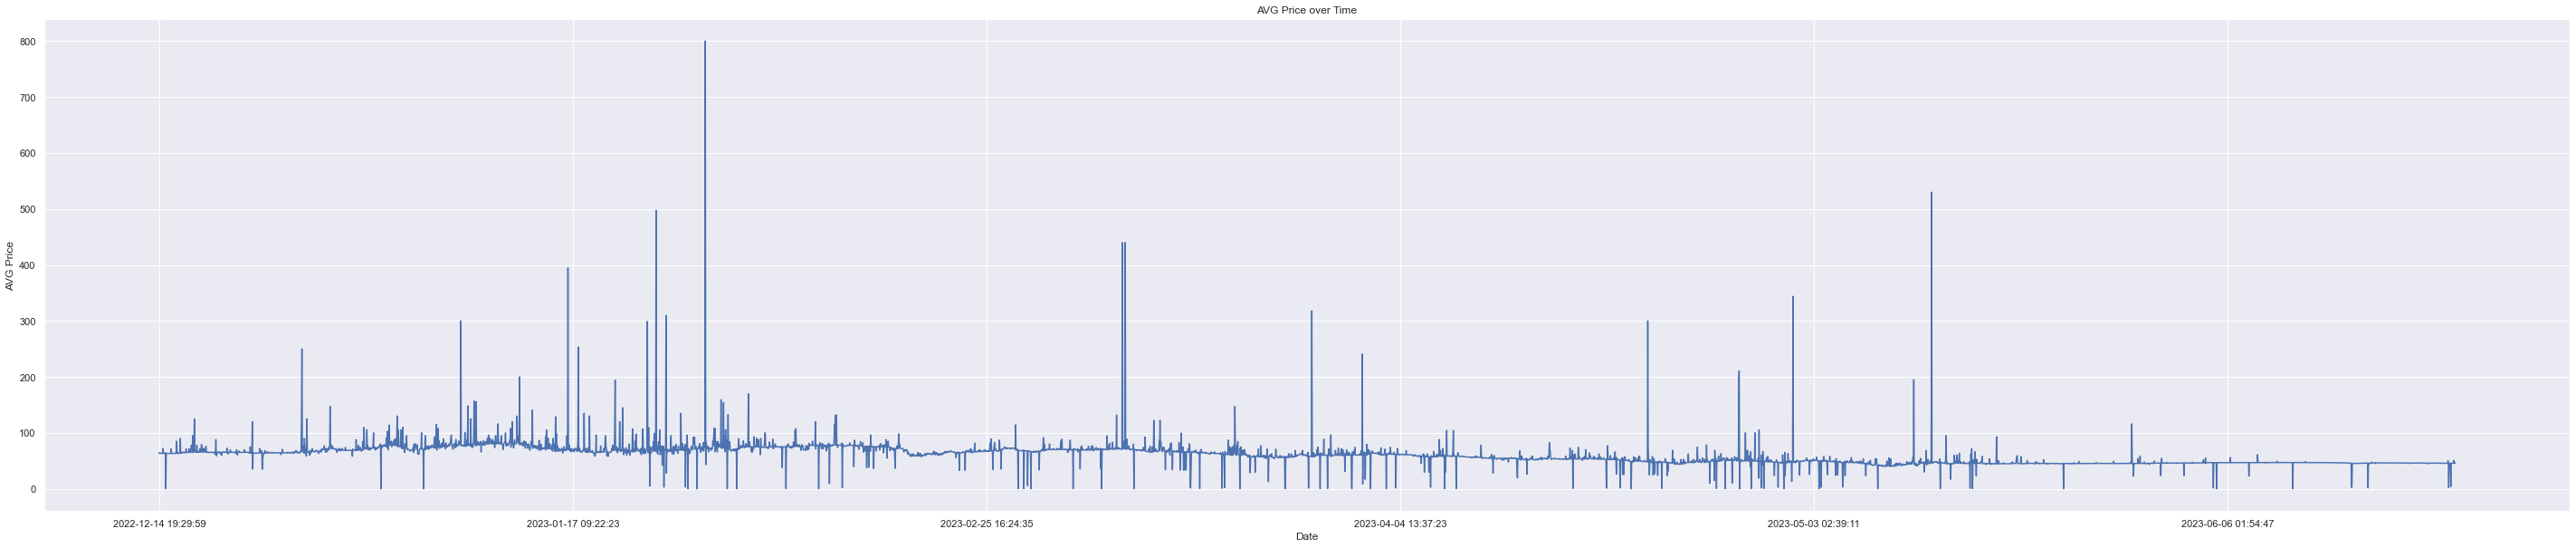

In [188]:
# AVG price over time

plt.figure(figsize=(50,10))
bayc_df.groupby('date')['price'].mean().plot()
plt.xlabel('Date')
plt.ylabel('AVG Price')
plt.title('AVG Price over Time')
plt.show()

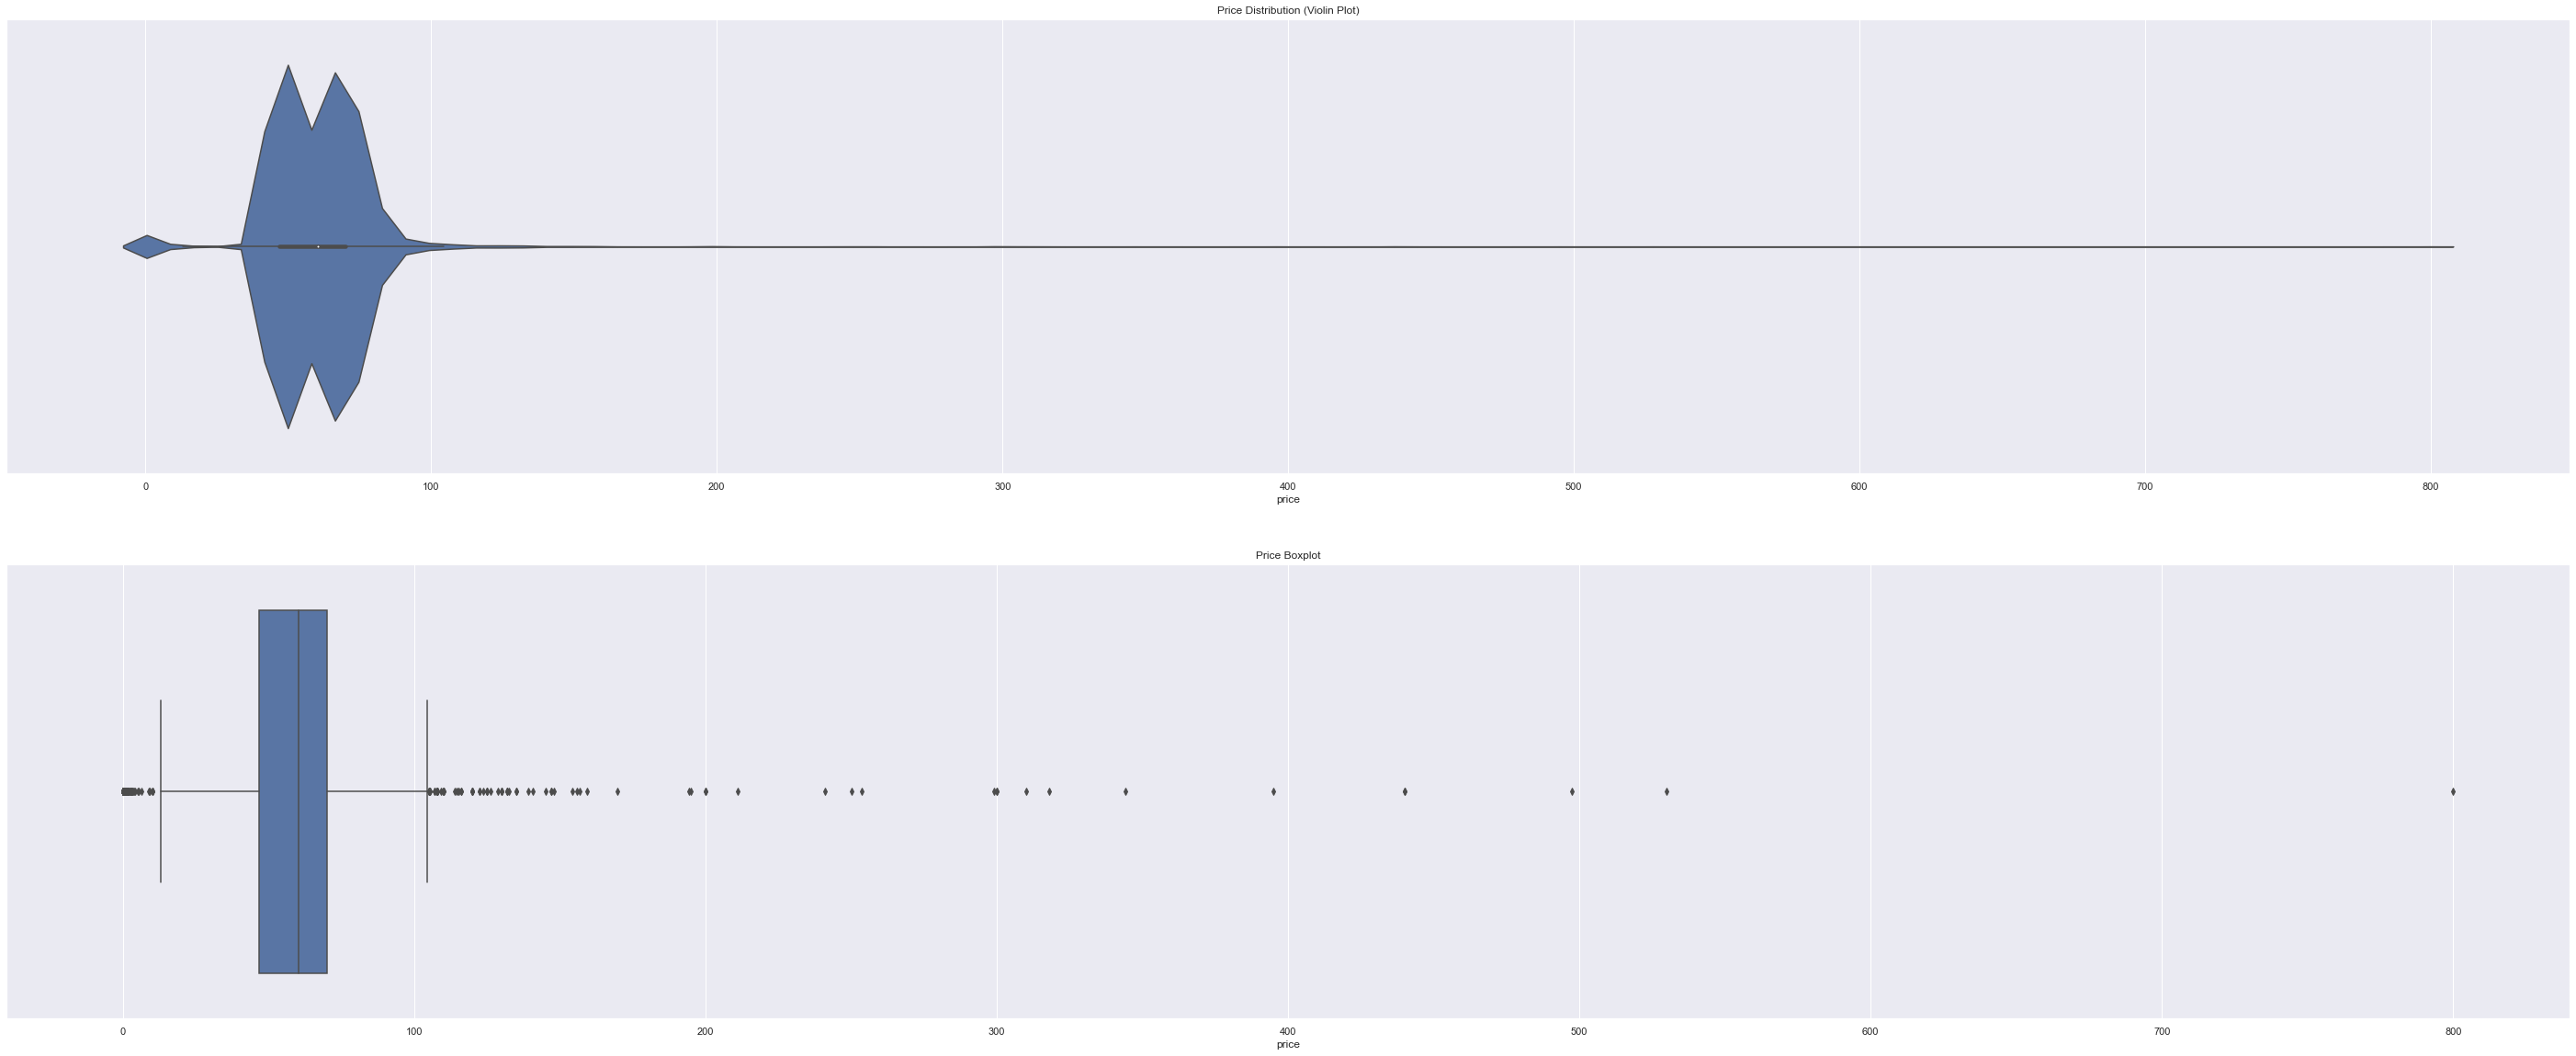

In [195]:
plt.figure(figsize=(50,20))

plt.subplot(2, 1, 1)
sns.violinplot(data=bayc_df, x='price')
plt.title('Price Distribution (Violin Plot)')

plt.subplot(2, 1, 2)
sns.boxplot(data=bayc_df, x='price')
plt.title('Price Boxplot')

plt.show()

# Outliers (1.5 IQR)

In [268]:
Q1 = bayc_df['price'].quantile(0.25)
Q3 = bayc_df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

bayc_df_new = bayc_df[(bayc_df['price'] >= lower_bound) & (bayc_df['price'] <= upper_bound)]

print(f'Num of outliers: {len(bayc_df) - len(bayc_df_new)}')

Num of outliers: 205


In [203]:
bayc_df_new.describe()

,tokenId,block,price,rarity,price_rounded
count,6795.00,6795.00,6795.00,6795.00,6795.00
mean,5016.53,16889855.16,60.00,7753868154.22,60.01
std,2876.34,396835.94,12.42,44929381715.73,12.43
min,27.00,16185032.00,12.94,165860.40,13.00
25%,2578.00,16645727.00,46.80,92587630.43,47.00
50%,4865.00,16897468.00,60.65,483669803.17,61.00
75%,7440.00,17256975.00,69.89,2671147596.58,70.00
max,9996.00,17452752.00,104.50,2135126471412.00,104.00


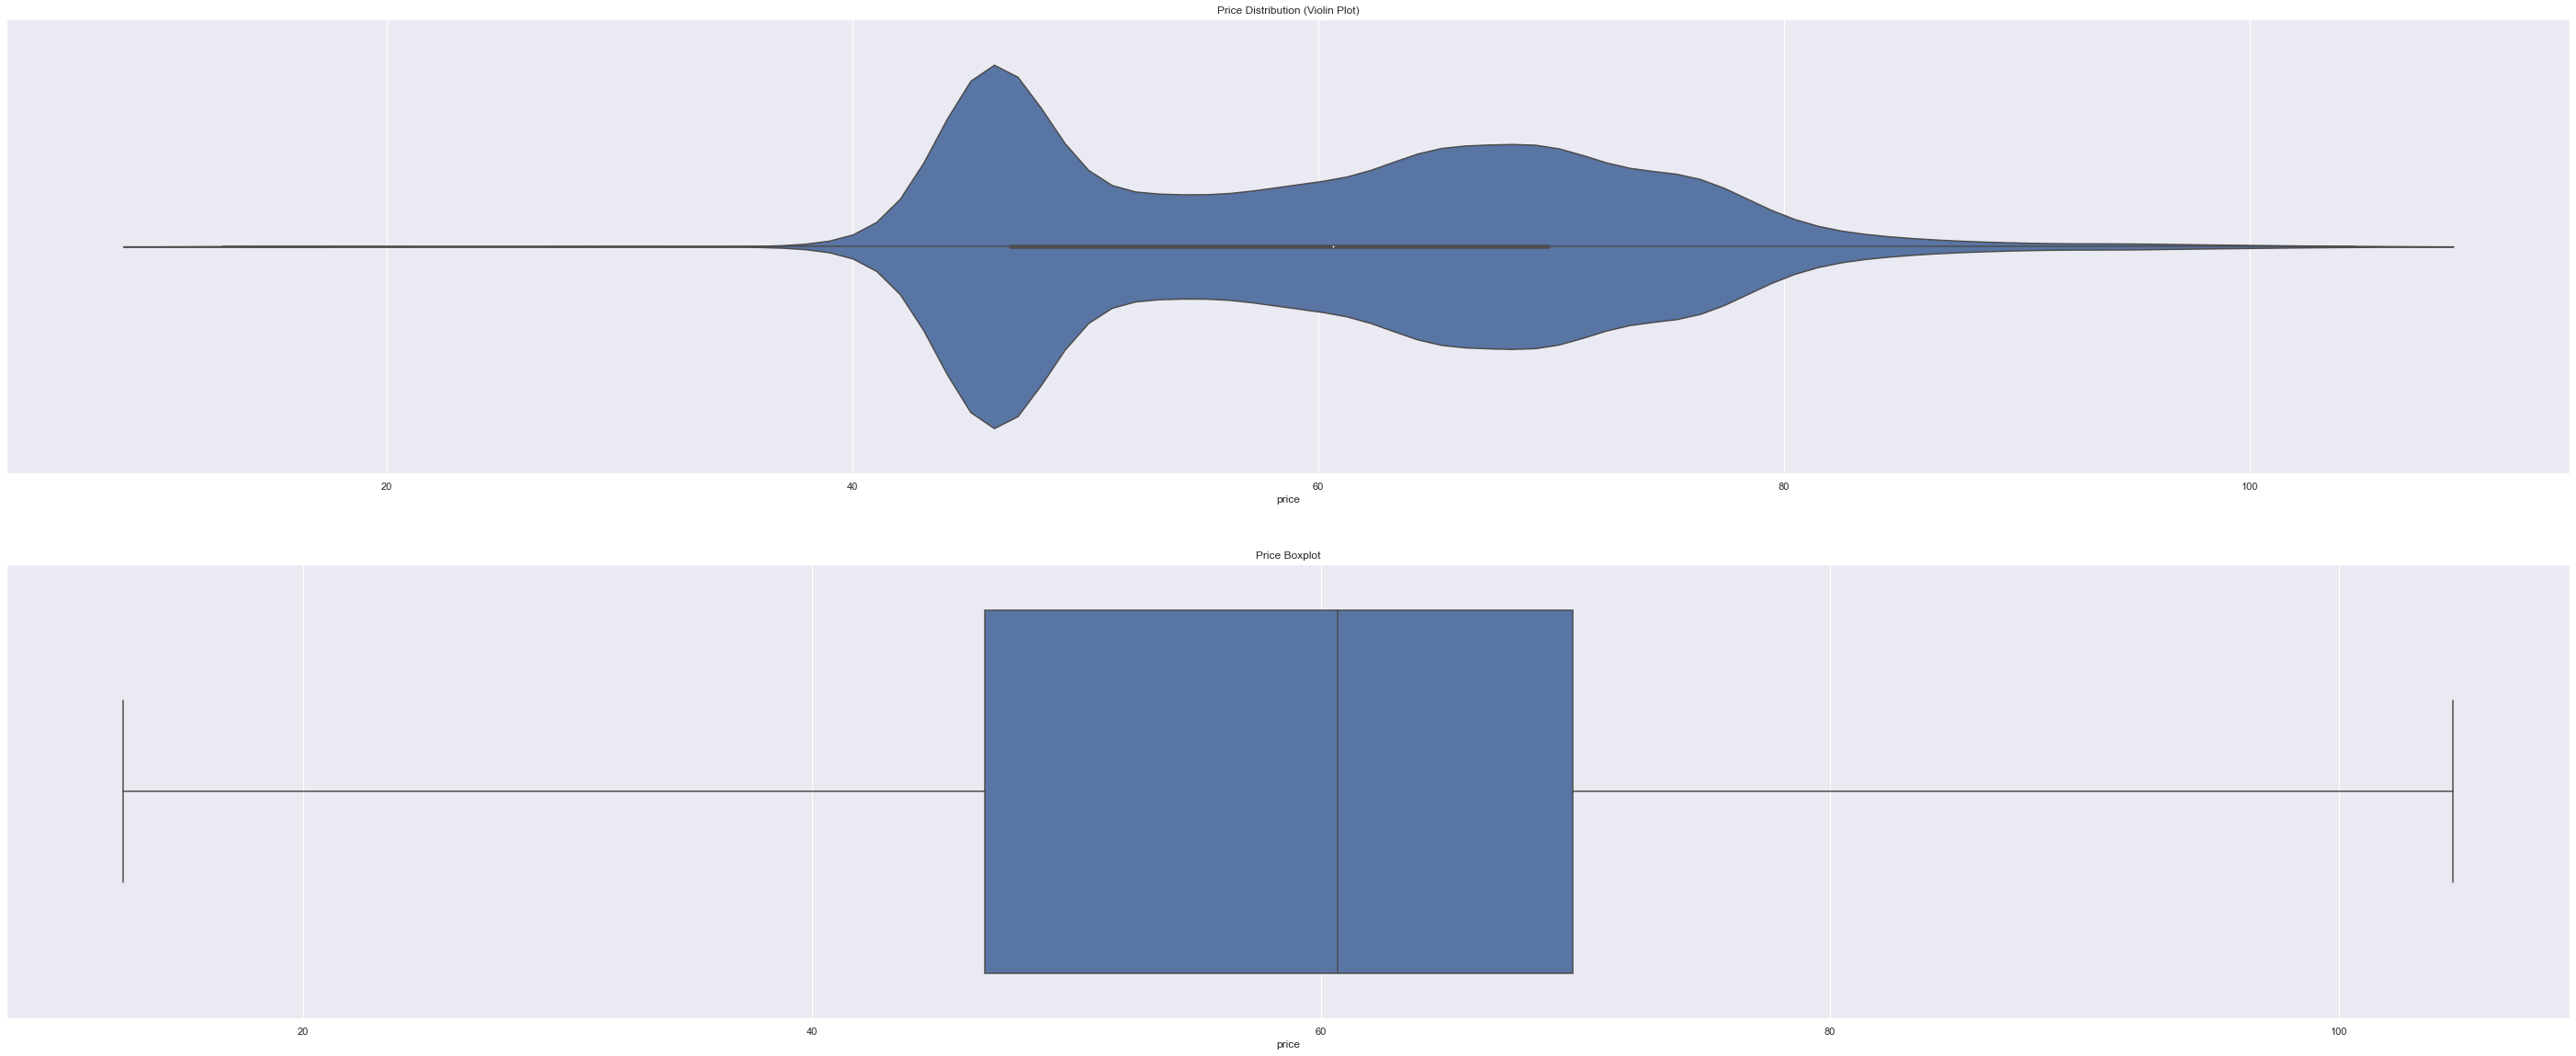

In [204]:
plt.figure(figsize=(50,20))

plt.subplot(2, 1, 1)
sns.violinplot(data=bayc_df_new, x='price')
plt.title('Price Distribution (Violin Plot)')

plt.subplot(2, 1, 2)
sns.boxplot(data=bayc_df_new, x='price')
plt.title('Price Boxplot')

plt.show()

# Adding tech indicators

In [269]:
def calculate_indicators(df):
    
    # Momentum Indicators
    df['roc'] = ta.momentum.ROCIndicator(close = df['price']).roc()
    df['rsi'] = ta.momentum.RSIIndicator(close = df['price']).rsi()
    df['stoch'] = ta.momentum.StochasticOscillator(high = df['price'], low = df['price'], close = df['price']).stoch()
    df['williams_r'] = ta.momentum.WilliamsRIndicator(high = df['price'], low = df['price'], close = df['price']).williams_r()

    # Volume Indicators
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close = df['price'], volume = df['price']).on_balance_volume()

    # Volatility Indicators
    df['atr'] = ta.volatility.AverageTrueRange(high = df['price'], low = df['price'], close = df['price']).average_true_range()
    df['bollinger_hband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_hband()
    df['bollinger_lband'] = ta.volatility.BollingerBands(close = df['price']).bollinger_lband()

    # Trend Indicators
    df['macd'] = ta.trend.MACD(close = df['price']).macd()
    df['cci'] = ta.trend.cci(high = df['price'], low = df['price'], close = df['price'])
    # df['sma_20'] = ta.trend.sma_indicator(df['price'], window=20)
    # df['sma_100'] = ta.trend.sma_indicator(df['price'], window=100)
    df['ema_20'] = ta.trend.ema_indicator(df['price'], window=20)
    df['ema_100'] = ta.trend.ema_indicator(df['price'], window=100)

    return df

In [270]:
df = calculate_indicators(bayc_df_new)

/var/folders/_7/zj5_y7pn4cx8qg43gs8vg9480000gn/T/ipykernel_30575/1176618731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['roc'] = ta.momentum.ROCIndicator(close = df['price']).roc()
/var/folders/_7/zj5_y7pn4cx8qg43gs8vg9480000gn/T/ipykernel_30575/1176618731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rsi'] = ta.momentum.RSIIndicator(close = df['price']).rsi()
/var/folders/_7/zj5_y7pn4cx8qg43gs8vg9480000gn/T/ipykernel_30575/1176618731.py:6: SettingWithCopyWarning: 
A value is trying to 

In [271]:
df.tail(5)

,tokenId,marketplace,block,token,price,rarity,date,roc,rsi,stoch,williams_r,obv,atr,bollinger_hband,bollinger_lband,macd,cci,ema_20,ema_100
6995,1971,blur,16185750,NaN,63.37,102484796.83,2022-12-14 21:54:11,-2.25,48.86,5.56,-94.44,143150.94,1.44,67.63,59.59,-0.07,-16.45,63.74,64.95
6996,6582,blur,16185745,NaN,63.37,249065298.50,2022-12-14 21:53:11,0.43,48.86,4.54,-95.46,143214.31,1.34,67.64,59.61,-0.10,-17.63,63.70,64.92
6997,910,blur,16185661,NaN,63.37,23412942758.50,2022-12-14 21:35:59,0.67,48.86,4.54,-95.46,143277.68,1.24,67.65,59.63,-0.11,-18.68,63.67,64.89
6998,3154,seaport,16185133,WETH,64.66,861691702.02,2022-12-14 19:50:23,2.61,52.64,18.51,-81.49,143342.34,1.25,67.75,59.70,-0.02,59.35,63.77,64.88
6999,2193,blur,16185032,NaN,63.00,230580442.87,2022-12-14 19:29:59,-0.06,47.75,0.00,-100.00,143279.34,1.28,67.75,59.69,-0.08,-45.58,63.69,64.84


In [212]:
# def calculate_intersections(df):
#     # sma crossover
#     df['signal_sma'] = 'buy'
#     df.loc[df['SMA_10'] < df['SMA_20'], 'signal_sma'] = 'sell'

#     # df['signal_sma'] = 'no signal'
#     # df['sma_diff'] = df['SMA_10'] - df['SMA_20']
#     # df.loc[(df['sma_diff'] > 0) & (df['sma_diff'].shift(1) < 0), 'signal_sma'] = 'buy'
#     # df.loc[(df['sma_diff'] < 0) & (df['sma_diff'].shift(1) > 0), 'signal_sma'] = 'sell'

#     # ema crossover
#     df['signal_ema'] = 'buy'
#     df.loc[df['EMA_10'] < df['EMA_20'], 'signal_ema'] = 'sell'

#     # macd and rsi
#     df['mr_signal'] = 'no signal'
#     df.loc[(df['MACD'] > 0) & (df['RSI'] < 30), 'mr_signal'] = 'buy'
#     df.loc[(df['MACD'] < 0) & (df['RSI'] > 70), 'mr_signal'] = 'sell'

#     # mbb
#     df['mbb_signal'] = 'no signal'
#     df.loc[(df['MACD'] > 0) & (df['price'] <= df['Bollinger_Low']), 'mbb_signal'] = 'buy'
#     df.loc[(df['MACD'] < 0) & (df['price'] >= df['Bollinger_High']), 'mbb_signal'] = 'sell'

#     # rbb
#     df['rbb_signal'] = 'no signal'
#     df.loc[(df['RSI'] < 30) & (df['price'] <= df['Bollinger_Low']), 'rbb_signal'] = 'buy'
#     df.loc[(df['RSI'] > 70) & (df['price'] >= df['Bollinger_High']), 'rbb_signal'] = 'sell'

    # return df

In [213]:
# df = calculate_intersections(df)

In [225]:
# df.tail(5)

,tokenId,marketplace,block,token,price,rarity,date,price_rounded,price_binned,SMA_10,...,RSI,Bollinger_High,Bollinger_Low,signal_sma,sma_diff,signal_ema,ema_diff,mr_signal,mbb_signal,rbb_signal
4,2844,blur,17452125,NaN,45.65,4763302967.40,2023-06-10 20:25:59,46.00,"[45, 50)",45.58,...,48.03,48.32,43.56,sell,-0.36,sell,-0.07,no signal,no signal,no signal
3,5609,blur,17452346,ETH,50.75,56649961.29,2023-06-10 21:10:47,51.00,"[50, 55)",46.13,...,76.98,49.36,43.04,sell,-0.07,buy,0.37,no signal,no signal,sell
2,6891,blur,17452371,NaN,45.54,33034156.13,2023-06-10 21:15:47,46.00,"[45, 50)",46.15,...,47.73,49.36,43.03,sell,-0.05,buy,0.24,no signal,no signal,no signal
1,6360,seaport,17452629,ETH,47.23,1724974815.60,2023-06-10 22:07:35,47.00,"[45, 50)",46.32,...,53.86,49.46,43.10,buy,0.04,buy,0.29,no signal,no signal,no signal
0,8507,seaport,17452752,WETH,45.50,1894522593.60,2023-06-10 22:32:23,46.00,"[45, 50)",46.30,...,47.69,49.46,43.09,buy,0.02,buy,0.16,no signal,no signal,no signal


# Modeling

In [288]:
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

In [272]:
df_reg = df.drop(['tokenId', 'marketplace', 'block', 'token'], axis=1)

In [273]:
df_reg.tail(5)

,price,rarity,date,roc,rsi,stoch,williams_r,obv,atr,bollinger_hband,bollinger_lband,macd,cci,ema_20,ema_100
6995,63.37,102484796.83,2022-12-14 21:54:11,-2.25,48.86,5.56,-94.44,143150.94,1.44,67.63,59.59,-0.07,-16.45,63.74,64.95
6996,63.37,249065298.50,2022-12-14 21:53:11,0.43,48.86,4.54,-95.46,143214.31,1.34,67.64,59.61,-0.10,-17.63,63.70,64.92
6997,63.37,23412942758.50,2022-12-14 21:35:59,0.67,48.86,4.54,-95.46,143277.68,1.24,67.65,59.63,-0.11,-18.68,63.67,64.89
6998,64.66,861691702.02,2022-12-14 19:50:23,2.61,52.64,18.51,-81.49,143342.34,1.25,67.75,59.70,-0.02,59.35,63.77,64.88
6999,63.00,230580442.87,2022-12-14 19:29:59,-0.06,47.75,0.00,-100.00,143279.34,1.28,67.75,59.69,-0.08,-45.58,63.69,64.84


In [278]:
df_reg = df_reg[100:]

In [281]:
df_reg = df_reg.dropna()

In [283]:
train, test = df_reg[df_reg['date'] < '2023-05-10'], df_reg[df_reg['date'] >= '2023-05-10']
train = train.drop('date', axis=1)
test = test.drop('date', axis=1)

In [284]:
x_train = train.drop('price', axis=1)
y_train = train['price']

x_test = test.drop('price', axis=1)
y_test = test['price']

In [285]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [289]:
# RANF
print('RandomForestRegressor')
ranf = RandomForestRegressor()
ranf.fit(x_train, y_train)
pred_ranf = ranf.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_ranf)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_ranf)}')

# TREE
print('DecisionTreeRegressor')
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_tree)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_tree)}')

# XGB
print('XGBRegressor')
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_xgb)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_xgb)}')

# CAT
print('CatBoostRegressor')
cat = CatBoostRegressor()
cat.fit(x_train, y_train)
pred_cat = cat.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_cat)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_cat)}')

RandomForestRegressor
RMSE: 3.0380671999632614
MAPE: 0.03825969865731645
DecisionTreeRegressor
RMSE: 5.048740433023235
MAPE: 0.056397967545292874
XGBRegressor
RMSE: 2.950997187489118
MAPE: 0.0374092539327333
CatBoostRegressor
Learning rate set to 0.052662
0:	learn: 9.9940625	total: 65ms	remaining: 1m 4s
1:	learn: 9.5667978	total: 66.4ms	remaining: 33.2s
2:	learn: 9.1514198	total: 68ms	remaining: 22.6s
3:	learn: 8.7585605	total: 69.9ms	remaining: 17.4s
4:	learn: 8.3948979	total: 71.4ms	remaining: 14.2s
5:	learn: 8.0471705	total: 72.7ms	remaining: 12.1s
6:	learn: 7.7123218	total: 74.2ms	remaining: 10.5s
7:	learn: 7.3931934	total: 75.8ms	remaining: 9.4s
8:	learn: 7.1067170	total: 77.6ms	remaining: 8.54s
9:	learn: 6.8197993	total: 79.1ms	remaining: 7.83s
10:	learn: 6.5481599	total: 80.6ms	remaining: 7.24s
11:	learn: 6.2992183	total: 82.1ms	remaining: 6.75s
12:	learn: 6.0561791	total: 83.6ms	remaining: 6.34s
13:	learn: 5.8234759	total: 85.2ms	remaining: 6s
14:	learn: 5.6107100	total: 87ms	r

In [294]:
# DROP EMAs
x_train = x_train.drop(['ema_20', 'ema_100'], axis=1)
x_test = x_test.drop(['ema_20', 'ema_100'], axis=1)

# RANF
print('RandomForestRegressor')
ranf = RandomForestRegressor()
ranf.fit(x_train, y_train)
pred_ranf = ranf.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_ranf)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_ranf)}')

# TREE
print('DecisionTreeRegressor')
tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)
pred_tree = tree.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_tree)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_tree)}')

# XGB
print('XGBRegressor')
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
pred_xgb = xgb.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_xgb)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_xgb)}')

# CAT
print('CatBoostRegressor')
cat = CatBoostRegressor()
cat.fit(x_train, y_train)
pred_cat = cat.predict(x_test)
print(f'RMSE: {rmse(y_test, pred_cat)}')
print(f'MAPE: {mean_absolute_percentage_error(y_test, pred_cat)}')

RandomForestRegressor
RMSE: 2.601770514546705
MAPE: 0.02943894165917201
DecisionTreeRegressor
RMSE: 4.266895205491015
MAPE: 0.04629004493521615
XGBRegressor
RMSE: 2.8003940294107186
MAPE: 0.035730944742563386
CatBoostRegressor
Learning rate set to 0.052662
0:	learn: 10.0179468	total: 2.9ms	remaining: 2.9s
1:	learn: 9.6085373	total: 4.29ms	remaining: 2.14s
2:	learn: 9.2187748	total: 5.68ms	remaining: 1.89s
3:	learn: 8.8511199	total: 7.25ms	remaining: 1.8s
4:	learn: 8.5036292	total: 8.91ms	remaining: 1.77s
5:	learn: 8.1563144	total: 10.6ms	remaining: 1.75s
6:	learn: 7.8311552	total: 12.3ms	remaining: 1.75s
7:	learn: 7.5216946	total: 14.3ms	remaining: 1.77s
8:	learn: 7.2208617	total: 16.2ms	remaining: 1.79s
9:	learn: 6.9421154	total: 18ms	remaining: 1.78s
10:	learn: 6.6877517	total: 19.5ms	remaining: 1.75s
11:	learn: 6.4343952	total: 21.1ms	remaining: 1.74s
12:	learn: 6.2006097	total: 22.9ms	remaining: 1.74s
13:	learn: 5.9968862	total: 24.4ms	remaining: 1.72s
14:	learn: 5.7787954	total: 2

In [295]:
ranf_features = pd.DataFrame({'feature':x_train.columns, 'importance':ranf.feature_importances_}).sort_values(by=['importance'], ascending=False)

In [296]:
ranf_features

,feature,importance
5,obv,0.62
7,bollinger_hband,0.12
10,cci,0.07
8,bollinger_lband,0.07
1,roc,0.06
2,rsi,0.04
9,macd,0.01
6,atr,0.00
0,rarity,0.00
3,stoch,0.00
